# House Prices: Advanced Regression Techniques

### AI TF 머신러닝 과제

* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* Predict sales prices and practice feature engineering, RFs, and gradient boosting

### File descriptions

* **input/train.csv** 테스트 셋
* **input/test.csv** 트레인 셋
* **input/data_description.txt** 데이터 설명
* **input/sample_sumbission.csv** 정답 제출 샘플

### Scikit-Learn RandomForest 모델 사용
* ** Kagle Score : 0.15898 **
* Linear Regression 과 동일한 feature 사용 시
* Hyper-parameter tunning 해도 크게 개선되지 않음
* feature 를 늘리거나 가공해서 try
* Categorical feature 들을 추가하고 one-hot-encoding 해서 try

In [185]:
import pandas as pd
import numpy as np

## Load Dataset

In [186]:
# train data
train = pd.read_csv("input/train.csv", index_col="Id")

print(train.shape)
train.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [187]:
# test data
test = pd.read_csv("input/test.csv", index_col="Id")

print(test.shape)
test.head()

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Preprocessing

#### linear regression 에서 feature 를 선택하는 방법
1. 데이터 탐색을 통해 SalePrice 와 선형 상관관계가 높고, 선형 regression 전제조건을 충족하는 feature 선택
2. 모든 feature 를 사용하고 Backward Elimination 을 통해 feature 를 줄여나가는 방법

#### sklearn linear regression 에서 feature scaling 이 필요한가?
1. linear regression 에서는 자동으로 feature scaling 되는것으로 알고 있음
   - SVN, K-Mean, Logistic Regression 처럼 feature scaling 이 필요한 모델들도 있음
   - from sklearn.preprocessing import StandardScaler 사용
2. lenear regression 에서 feature scaling 을 했을경우와 안했을경우 차이를 확인해 보자
   - 차이가 없음 : 자동으로 feature scaling 되고 있음

### outlier

1. 'GrLiveArea' 의 outlier 데이터 제거 

In [188]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train.index == 1299].index)
train = train.drop(train[train.index == 524].index)
print(train.shape)

(1458, 80)


In [189]:
# 데이터 탐색을 통해 linear regression 에 적합한 feature 선정 함

# train 시킬 feature 선언
# YearBuilt 가 있을경우 score 가 좋아지는것을 확인
feature_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath','YearBuilt']
                #'GarageArea', '1stFlrSF', 'TotRmsAbvGrd']

In [190]:
# train 시킬 데이터셋
X_train = train.loc[:, feature_names]

# YearBuilt 에 공백값이 있는 데이터가 한건 있어서 임의의 값으로 업데이트
X_train.loc[train["YearBuilt"] == " ", "YearBuilt"] = 1980

# YearBuil 가 object type 이어서 수치형으로 변환
pd.to_numeric(X_train['YearBuilt'])
print(X_train.shape)
X_train.head()

(1458, 6)


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
Id,,,,,,
1,7,1710,2,856,2,2003
2,6,1262,2,1262,2,1976
3,7,1786,2,920,2,2001
4,7,1717,3,756,1,1915
5,8,2198,3,1145,2,2000


### missing data in X_train

In [191]:
#missing data
total = X_train.isnull().sum().sort_values(ascending=False)
percent = (X_train.isnull().sum()/X_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
YearBuilt,0,0.0
FullBath,0,0.0
TotalBsmtSF,0,0.0
GarageCars,0,0.0
GrLivArea,0,0.0
OverallQual,0,0.0


In [192]:
X_test = test.loc[:, feature_names]
print(X_test.shape)
X_test.head()

(1459, 6)


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
Id,,,,,,
1461,5,896,1.0,882.0,1,1961
1462,6,1329,1.0,1329.0,1,1958
1463,5,1629,2.0,928.0,2,1997
1464,6,1604,2.0,926.0,2,1998
1465,8,1280,2.0,1280.0,2,1992


### missing data in X_test

In [193]:
#missing data
total = X_test.isnull().sum().sort_values(ascending=False)
percent = (X_test.isnull().sum()/X_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TotalBsmtSF,1,0.000685
GarageCars,1,0.000685
YearBuilt,0,0.000000
FullBath,0,0.000000
GrLivArea,0,0.000000
OverallQual,0,0.000000


In [194]:
# TotalBsmtSF null 값 확인
X_test[X_test['TotalBsmtSF'].isnull()]

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
Id,,,,,,
2121,4,896,1.0,NaN,1,1946


In [195]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test["TotalBsmtSF"]=imp.fit_transform(X_test[["TotalBsmtSF"]]).ravel()

# total_bsmtsf_mean = X_test['TotalBsmtSF'].mean()
# X_test.loc[X_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = total_bsmtsf_mean

In [196]:
# GarageCars null 값 확인
X_test[X_test['GarageCars'].isnull()]

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt
Id,,,,,,
2577,5,1828,NaN,859.0,2,1923


In [197]:
# 결측치를 평균값으로 채움
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_test["GarageCars"]=imp.fit_transform(X_test[["GarageCars"]]).ravel()

# garagecars_mean = X_test['GarageCars'].mean()
# X_test.loc[X_test['GarageCars'].isnull(), 'GarageCars'] = garagecars_mean

### feature scaling

RandomForestRegressor 는 feature scaling 이 필요 없음

In [198]:
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

### One hot encoding

OverallQual 값은 수치형이지만 categories 로 봐야 함

One hot encoding 했을 경우와 안했을 경우 결과의 차이를 확인해 보자
- One hot encoding 방법은 다양함

수치형 Categories 데이터를 One hot encoding 하면 결과가 더 않 좋아지는것 같음

In [199]:
# OneHotEncoder 사용
#from sklearn.preprocessing import OneHotEncoder
# 첫번째 컬럼인 OverallQual 를 encoding 대상으로 지정
#ohe = OneHotEncoder(categorical_features = [0])
# train 데이터 encoding
#X_train = ohe.fit_transform(X_train).toarray()
# test 데이터 encoding
#X_test = ohe.fit_transform(X_test).toarray()

### model 

In [200]:
# train 시킬 때 사용할 label(target, 종속변수) 컬럼 선택
label_name = "SalePrice"

# train 시킬 때 사용할 label(target, 종속변수) 데이터셋 준비
y_train = np.log(train[label_name])

print(y_train.shape)
y_train.head()

(1458,)


Id
1    12.247694
2    12.109011
3    12.317167
4    11.849398
5    12.429216
Name: SalePrice, dtype: float64

In [201]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300,
                              max_depth=9,
                              max_features=0.45,
                              random_state=37)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=0.45, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

### Scoring

Kaggle 에서 log 함수로 변환된 SalePrice 값을 RMSE 방식으로 scoring 하기 때문에 RMSE 함수 구현하여 사용

In [202]:
# RMSE 함수 구현
import numpy as np
from sklearn.metrics import make_scorer

def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
  
    difference = predict - actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmse_scorer = make_scorer(rmse)
rmse_scorer

make_scorer(rmse)

In [203]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(model, X_train, y_train, cv=10, \
                         scoring=rmse_scorer).mean()

print("Score = {0:.5f}".format(score))

Score = 0.15564


## Hyperparameter Tuning
https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

In [159]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 300
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=5, high=20)
    max_features = np.random.uniform(low=0.4, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=10, \
                            scoring=rmse_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.15846
Score = 0.15749
Score = 0.15649
Score = 0.15776
Score = 0.15755
Score = 0.15588
Score = 0.15768
Score = 0.15854
Score = 0.15569
Score = 0.15578
(10, 4)


,max_depth,max_features,n_estimators,score
8,15,0.432414,300,0.155690
9,19,0.475800,300,0.155781
5,16,0.552694,300,0.155881
2,13,0.622343,300,0.156486
1,12,0.738073,300,0.157493


## Train

In [204]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=0.45, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

### Calculate feature importances

In [205]:
importances = model.feature_importances_
importance_by_feature = list(zip(feature_names, importances))
importance_by_feature

[('OverallQual', 0.30284631552980412),
 ('GrLivArea', 0.23405863516826575),
 ('GarageCars', 0.098342225884578041),
 ('TotalBsmtSF', 0.12026110975471613),
 ('FullBath', 0.066190329830418934),
 ('YearBuilt', 0.17830138383221744)]

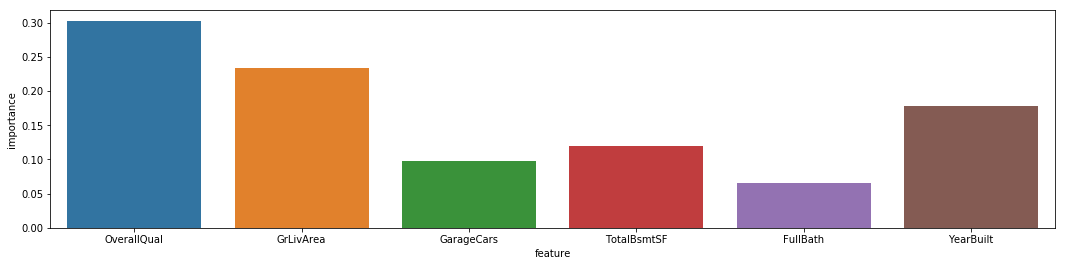

In [206]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

importance_df = pd.DataFrame(importance_by_feature, columns=['feature', 'importance'])
sns.barplot(data=importance_df, x='feature', y='importance', ax=ax1)

## Predict

In [207]:
# RMSE scoreing 하기 위해 log로 변환했던 값을 다시 원복해야 함
predictions = np.exp(model.predict(X_test))
print(predictions.shape)
predictions

(1459,)


array([ 122315.97317578,  146703.29846219,  169727.82148259, ...,
        142754.22185648,  110694.42209361,  239465.81073699])

## Submit (kaggle 제출용)

In [208]:
submission = pd.read_csv("input/sample_submission.csv", index_col="Id")

submission["SalePrice"] = predictions

print(submission.shape)
submission.head()

(1459, 1)


,SalePrice
Id,
1461,122315.973176
1462,146703.298462
1463,169727.821483
1464,181520.337720
1465,200822.968426


In [209]:
# 저장할 파일을 구분하기 위해 파일명에 timestamp 정보 추가 하기 위한 작업 
from datetime import datetime

current_date = datetime.now()
current_date = current_date.strftime("%Y-%m-%d_%H-%M-%S")

description = "random-forest-regression"

filename = "{date}_{desc}_{score}.csv".format(date=current_date, desc=description, score="{0:.5f}".format(score))
filepath = "output/{filename}".format(filename=filename)

submission.to_csv(filepath)